In [1]:
from datasets import FishTox

dataset = FishTox('/data')

/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io

In [2]:
# from fingerprinter import *
# 
# fingerprinters = [
#     SubstructureFingerprintCount(),
#     PubchemFingerprinter(),
#     MACCSFingerprinter(),
#     KlekotaRothFingerprintCount(),
#     EStateFingerprinter(),
#     ChemBERTaFingerprinter(),
#     AtomPairs2DFingerprinter()    
# ]
# # 
# fingerprinters = [
#     CachedFingerprinter(
#         '/data/fingerprints',
#         fingerprinter,
#         read_only=True
#     ) for fingerprinter in fingerprinters
# ]

from encoder import *

encoders = []
for pool in ['mean']:#, 'sum']:#, 'sum', 'max']:
    encoders += [
        ChemBERTaEncoder(pool=pool),
        MolCLREncoder(architecture='GIN', pool=pool),
        # MolCLREncoder(architecture='GCN', pool=pool),
        MoleBERTEncoder(pool=pool)
    ]
# 
encoders += [KPGTEncoder()]
encoders

Instantiating the model.


/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1581: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']


Opening /data/representations/ChemBERTa_zinc250k_v2_40k_mean/values.h5py
Closing /data/representations/MoleBERT_mean/values.h5py
[Info]: batch_size is not specified, using batch_size=64 by default.
Opening /data/representations/MolCLR_GIN_mean/values.h5py
Closing /data/representations/ChemBERTa_zinc250k_v2_40k_mean/values.h5py
[Info]: batch_size is not specified, using batch_size=64 by default.
Opening /data/representations/MoleBERT_mean/values.h5py
Closing /data/representations/MolCLR_GIN_mean/values.h5py
[Info]: batch_size is not specified, using batch_size=64 by default.
Opening /data/representations/KPGT_base/values.h5py
Closing /data/representations/MoleBERT_mean/values.h5py
[Info]: batch_size is not specified, using batch_size=64 by default.


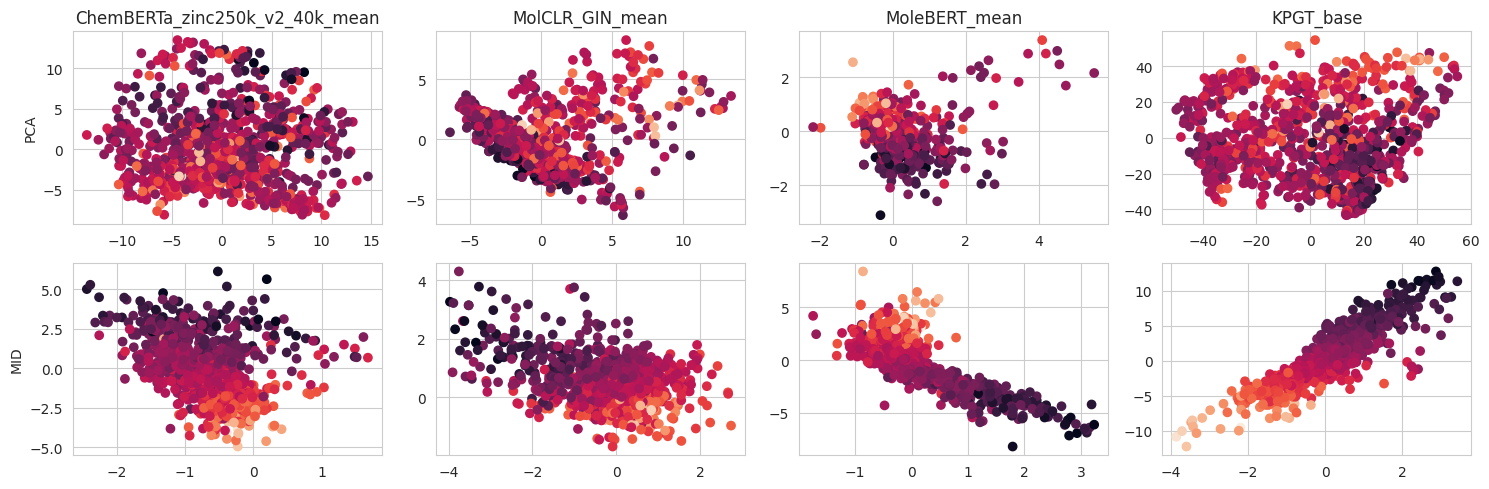

In [4]:
from torch.utils.data import Subset
from datasets.utils import prepare_molecular_dataset
from torch_mist.decomposition import MID
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


targets = dataset.y

f, ax = plt.subplots(2,len(encoders), figsize=(15, 5))

ax[0,0].set_ylabel('PCA')
ax[1,0].set_ylabel('MID')

for i, encoder in enumerate(encoders):
    name = encoder.name
    encoded_dataset = prepare_molecular_dataset(dataset, encoder, representation_path='/data/representations', read_only=False)
    
    Z = []
    Y = []
    for z, y in encoded_dataset:
        Z.append(z.reshape(1,-1))
        Y.append(y.reshape(1,-1))
        
    Z = np.concatenate(Z, 0)
    Y = np.concatenate(Y, 0)
    

    proj = PCA(2)
    proj.fit(Z)
    z = proj.transform(Z)
    ax[0,i].set_title(name)
    ax[0,i].scatter(z[:,0],z[:,1],c=Y[:,0])
    
    # proj = MID(2, normalize_inputs=name=='ChemBERTa', proj_params={'hidden_dims': []})
    # proj.fit(fingerprints, targets, max_iterations=10000, early_stopping=True, patience=10)
    # z = proj.transform(fingerprints_)
    # ax[1,i].scatter(z[:,0],z[:,1],c=targets_)   
    

    proj = MID(2, normalize_inputs=True, proj_params={'hidden_dims': [128]})
    proj.fit(Z, Y, 
             max_iterations=10000, early_stopping=True, patience=10, warmup_percentage=0.01, verbose=False)
    z = proj.transform(Z)
    ax[1,i].scatter(z[:,0],z[:,1],c=Y[:,0])   
    
    
plt.tight_layout()
plt.savefig('figures/fishtox_mid.png')
    

In [4]:
Z.shape

(907, 300)

ValueError: too many values to unpack (expected 2)